# mAP implementation

In [25]:
import numpy as np
import tensorflow as tf
import sys, os, datetime
sys.path.append('/home/andrea/AI/ispr_yolo/data')
sys.path.append('/home/andrea/AI/ispr_yolo/model')
from utils import broadcast_iou
from postprocessor import *
import matplotlib.pyplot as plt
import cv2 as cv
from pathlib import Path

class meanAveragePrec:
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, all_true_box, all_pred_box):
        result = {}
        for class_ in all_true_box.keys():
            result[class_] = self.single_class(all_true_box[class_][0], all_pred_box[class_][0])
        return result
    
    def filter_one(self, true_box, pred_box, ):
        
    def single_class(self, true_box, pred_box):
        # for every ground truth BB it calculates its IoU over the BB predictions
        iou = broadcast_iou(true_box, pred_box)
        # for every ground thruth BB it keeps the best IoU over BB predictions
        best_iou = tf.reduce_max(iou, axis=-1)
        result = tf.cast(best_iou > self.threshold, tf.float32)
        true_positives = tf.reduce_sum(result)
        
        false_negatives = tf.cast(tf.shape(true_box)[0], tf.float32) - true_positives
        false_positives = tf.cast(tf.shape(pred_box)[0], tf.float32) - true_positives
        
        return np.array([true_positives, false_negatives, false_positives], dtype = np.int64)

### Testing Script

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 2
True boxes shape:  tf.Tensor([5 4], shape=(2,), dtype=int32)
Predicted boxes shape:  tf.Tensor([4 4], shape=(2,), dtype=int32)
IoU ground truth over predictions:  tf.Tensor([5 4], shape=(2,), dtype=int32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0.8, shape=(), dtype=float32)
None


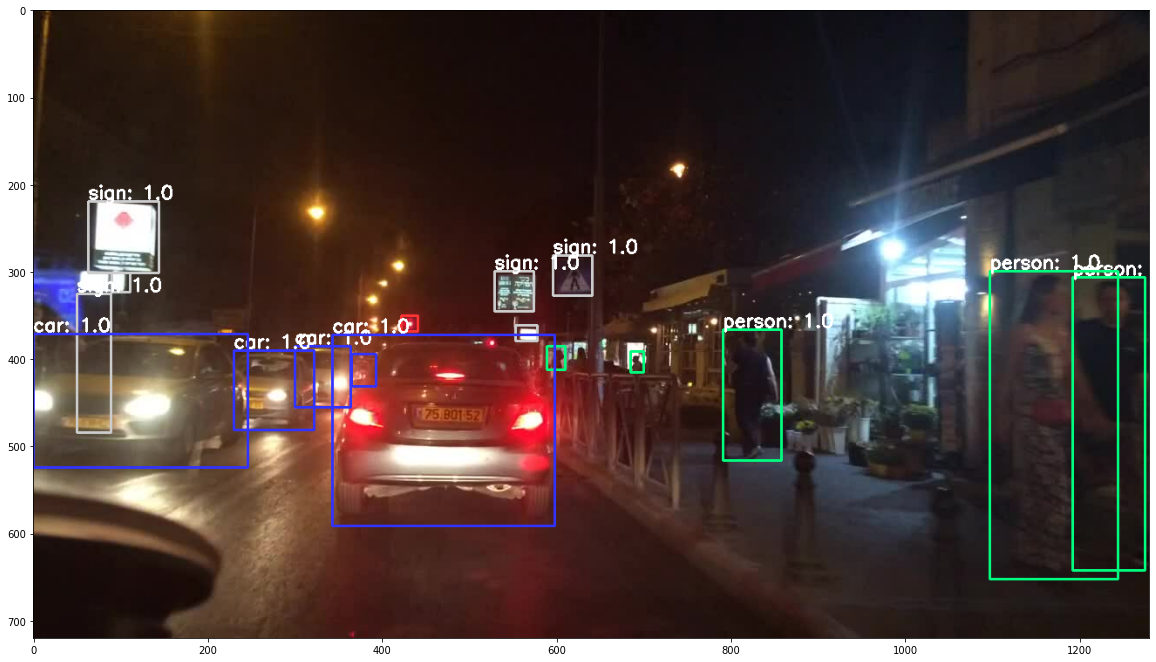

In [26]:
strategy = tf.distribute.MirroredStrategy(devices=[ "/gpu:2", "/gpu:3"])
weights_path = '/home/andrea/AI/ispr_yolo/NOTEBOOKS/training/logs/fit/1102-215356ep009-loss23.113-val_loss31.695.h5'
test_set_path = Path('/home/andrea/AI/ispr_yolo/data/dataset_bdd/images/100k/val/')

with strategy.scope():
    yolo = create_model(weights_path)
    test = Path('/home/andrea/AI/ispr_yolo/data/dataset_bdd/images/100k/val/')
    test = test.glob('*.jpg')
    accuracy = meanAveragePrec(0.5)
    counter = 1
    for image_path in test:
        img, boxes, boxes_ground = show_me(yolo, str(image_path))       
        partial_result = accuracy(boxes_ground, boxes)
        if counter == 1:
            result = partial_result
        else:
            for class_ in result.keys():
                result[class_] = result[class_] + partial_result[class_]
        counter += 1
        if counter%100 == 0: print(counter/100, '%')
    print(result)


In [ ]:
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:2", "/gpu:3"])
# weights_path = '/home/andrea/AI/ispr_yolo/NOTEBOOKS/training/softmax_augmented/fit/1028-190344ep008-loss109.459-val_loss124.646.h5'
# with strategy.scope():
#     yolo = create_model(weights_path)
    

In [ ]:
#     img_path = '/home/andrea/AI/ispr_yolo/data/dataset_bdd/images/100k/val/c96a9fb4-cacac0fc.jpg'
#     img, boxes, boxes_ground = show_me(yolo, img_path)
#     img2 = tf.identity(img)
#     img = draw_boxes(img, boxes)
#     img2 = draw_boxes(img2, boxes_ground)

#     model_cars = boxes['bus'][0]
#     ground_cars = boxes_ground['bus'][0]
    
#     accuracy = meanAveragePrec(0.5)
#     print(accuracy.single_class(ground_cars, model_cars))
    
#     plt.figure(figsize = (20,20))
#     _ = plt.imshow(img[280:1000])
    
#     plt.figure(figsize = (20,20))
#     _ = plt.imshow(img2[280:1000])